In [1]:
import configparser 
import pandas as pd
import boto3
import matplotlib.pyplot as plt

# Load AWS credentials
config = configparser.ConfigParser()
config.read('aws.cfg')

aws_access_key_id = config['AWS']['aws_access_key_id']
aws_secret_access_key = config['AWS']['aws_secret_access_key']
region_name = config['AWS']['region_name']

s3 = boto3.client(
    's3',
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key
)
response = s3.list_buckets()

In [2]:
rekognition_client = boto3.client(
    'rekognition',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region_name
)

comprehend_client = boto3.client(
    'comprehend',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=region_name
)

In [4]:
product = pd.read_csv('s3://techcatalyst-public/resources/sentiment/product.csv')
review = pd.read_csv('s3://techcatalyst-public/resources/sentiment/review.csv')

In [20]:
def detect_sentiment(review):
    response = comprehend_client.detect_sentiment(Text=review[0], LanguageCode='en')
    return response["Sentiment"]

In [20]:
combined_df = pd.merge(product, review, on='REVIEW ID')

sentiment = []
for i in combined_df['REVIEW TEXT']:
    sentiment.append(comprehend_client.detect_sentiment(Text=i, LanguageCode='en')['Sentiment'])

combined_df['Sentiment'] = sentiment
display(combined_df)

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,Sentiment
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE
5,3,Wireless noise-canceling headphones.,R6,Not comfortable to wear for long periods.,NEGATIVE
6,4,Smartwatch with various health tracking features.,R7,Great health tracking features but too expensive.,MIXED
7,4,Smartwatch with various health tracking features.,R8,Love the design and functionality. Would buy a...,POSITIVE
8,5,Portable Bluetooth speaker with rich sound.,R9,Sound quality is amazing for its size.,POSITIVE
9,5,Portable Bluetooth speaker with rich sound.,R10,Battery life is too short for outdoor use.,NEGATIVE


In [22]:
combined_df.to_csv('s3://techcatalyst-public/kaitlyn/product_sentiment.csv')

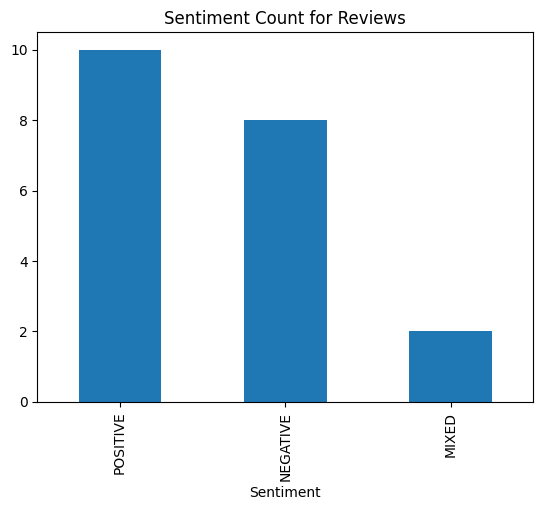

In [55]:
ax1 = combined_df['Sentiment'].value_counts().plot(kind="bar")
ax1 = plt.title("Sentiment Count for Reviews")
ax1 = plt.xlabel("Sentiment")

plt.savefig("sentiment_count.jpg", format='jpg')

s3.upload_file('sentiment_count.jpg', 'techcatalyst-public', 'kaitlyn/sentiment_count.jpg')

In [3]:
s3_paginator = s3.get_paginator('list_objects_v2')
s3_page_iterator = s3_paginator.paginate(
    Bucket='techcatalyst-public',
    Prefix='resources/license-plates/'
)

s3_object_key_list = []

# Get the S3 response for each page of the iterator
for s3_page_response in s3_page_iterator:
    # Get the list of S3 objects for each page response
    for s3_object in s3_page_response['Contents']:
        # Add the s3_object_key to the list of S3 object keys
        s3_object_key_list.append(s3_object['Key'])

license_plate_file = []
for s3_object_key in s3_object_key_list:
    if '.jpeg' in s3_object_key or '.png' in s3_object_key or 'jpg' in s3_object_key:
        license_plate_file.append(s3_object_key)

In [4]:
license_plate_file

['resources/license-plates/license_plate10.jpeg',
 'resources/license-plates/license_plate11.png',
 'resources/license-plates/license_plate12.jpeg',
 'resources/license-plates/license_plate13.jpeg',
 'resources/license-plates/license_plate3.png',
 'resources/license-plates/license_plate4.jpeg',
 'resources/license-plates/license_plate6.jpeg',
 'resources/license-plates/license_plate7.jpg',
 'resources/license-plates/license_plate8.png',
 'resources/license-plates/license_plate9.jpeg']

In [15]:
state = {}
file_names = []
states = pd.read_csv('s3://techcatalyst-public/resources/license-plates/states.csv')

for file in license_plate_file:
    for i in rekognition_client.detect_text(Image={"S3Object": {"Bucket": 'techcatalyst-public', "Name": file}})['TextDetections']:
        if i['DetectedText'].lower() in [t.lower() for t in list(states['0'])]:
            state.setdefault(file, i['DetectedText'])

In [14]:
license_plate_states = pd.DataFrame(state.items(), columns=['Image', 'State'])
license_plate_states['State'] = license_plate_states['State'].apply(lambda x: x.lower().capitalize())
display(license_plate_states)

,Image,State
0,resources/license-plates/license_plate10.jpeg,Arizona
1,resources/license-plates/license_plate11.png,Texas
2,resources/license-plates/license_plate12.jpeg,Texas
3,resources/license-plates/license_plate13.jpeg,Alabama
4,resources/license-plates/license_plate3.png,Massachusetts
5,resources/license-plates/license_plate4.jpeg,Pennsylvania
6,resources/license-plates/license_plate6.jpeg,California
7,resources/license-plates/license_plate7.jpg,Nevada
8,resources/license-plates/license_plate8.png,Ohio
9,resources/license-plates/license_plate9.jpeg,Alabama


In [16]:
license_plate_states.to_csv('s3://techcatalyst-public/kaitlyn/image_state.csv')

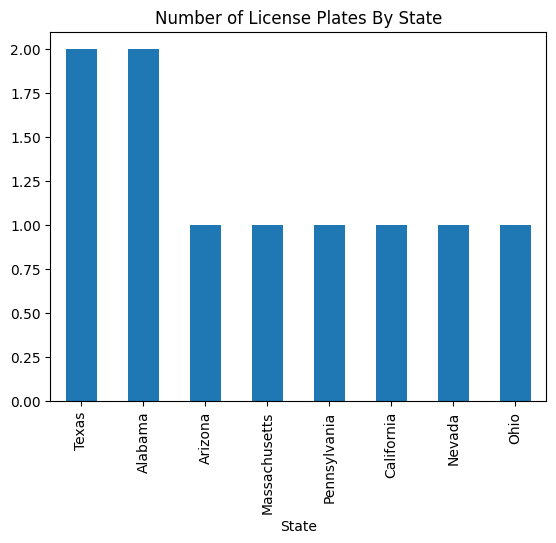

In [18]:
ax2 = license_plate_states['State'].value_counts().plot(kind="bar")
ax2 = plt.title("Number of License Plates By State")
ax2 = plt.xlabel("State")

plt.savefig("license_plates_by_state.jpg", format='jpg')

s3.upload_file('license_plates_by_state.jpg', 'techcatalyst-public', 'kaitlyn/license_plates_by_state.jpg')